# Surfs Up!
____

### 1 - Climate Analysis and Exploration
____

#### Dependencies
____

In [2]:
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

from datetime import datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

#### SQLite
_____

In [3]:
database_path = "../resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}", echo=False)

#### SQLAlchemy
____

In [4]:
Base = automap_base()
Base.prepare(engine, reflect=True)

Measurement = Base.classes.measurement
Station = Base.classes.station

session = Session(engine)

### Precipitation Analysis
_____

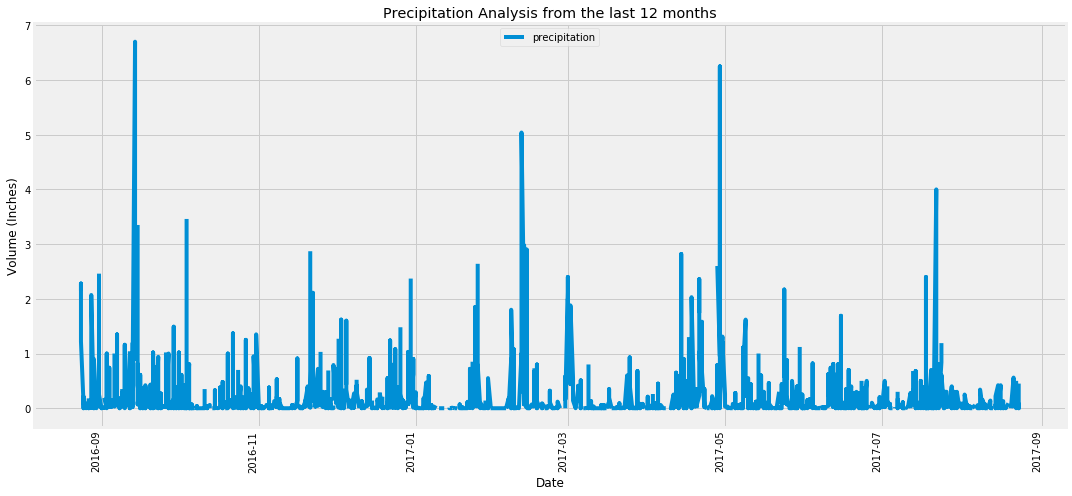

In [5]:
# Design a query to retrieve the last 12 months of precipitation data.
max_date = datetime.strptime(session.query(func.max(func.Date(Measurement.date))).scalar(), '%Y-%m-%d')
date_base = max_date - relativedelta(months=12) 

query = session.query(Measurement.date, Measurement.prcp.label('precipitation')).filter(func.Date(Measurement.date) > func.Date(date_base))
precipitation = pd.read_sql(query.statement, session.bind,index_col='date', parse_dates=['date'])
precipitation.sort_index(ascending=True, inplace=True)

precipitation.plot(y='precipitation', figsize=(15,7), title='Precipitation Analysis from the last 12 months')

plt.xlabel("Date")
plt.ylabel("Volume (Inches)")
plt.xticks(rotation='vertical')
plt.autoscale(enable=True,axis='both')

plt.grid(True)
plt.legend(loc='upper center')

plt.tight_layout()

In [6]:
precipitation.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis
_____

In [7]:
# Design a query to calculate the total number of stations.
total_stations = session.query(Station.id).count()

print (f'Total of stations : {total_stations}')

Total of stations : 9


In [8]:
# List the stations and observation counts in descending order.
query = session.query(Measurement.station, func.count(Measurement.station).label('Observations')).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

pd.read_sql(query.statement, session.bind, index_col='station' )

,Observations
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [9]:
# Which station has the highest number of observations?

station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).first()

print (f'Station with the highest number of observations({station[1]}) : {station[0]}')

Station with the highest number of observations(2772) : USC00519281


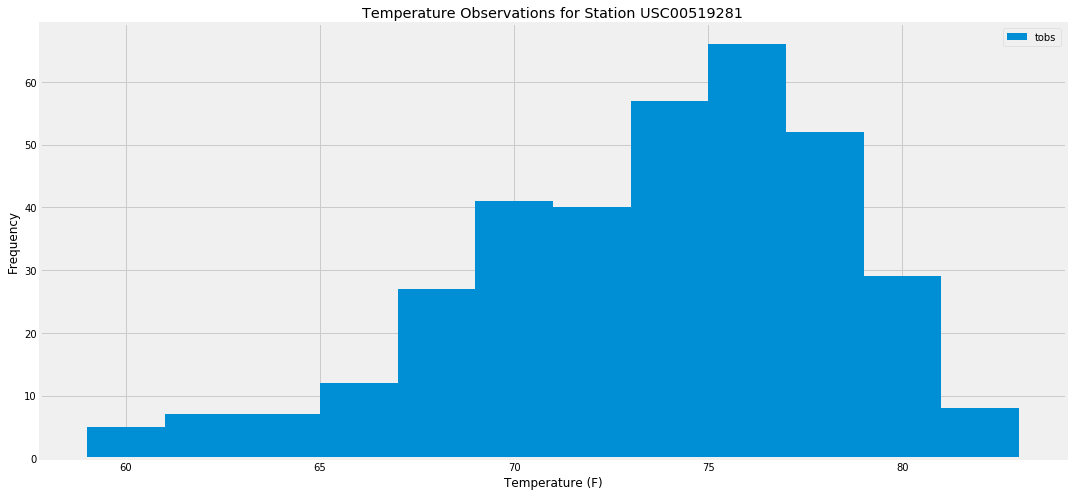

In [10]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs)
# Filter by the station with the highest number of observations.
query = session.query(Measurement.station, Measurement.tobs).filter(func.Date(Measurement.date) > func.Date(date_base)).filter(Measurement.station == station[0])
tobs = pd.read_sql(query.statement, session.bind,index_col='station')

# Plot the results as a histogram with bins=12
tobs.plot.hist(by='station', bins=12,  figsize=(15,7),)

plt.title(f'Temperature Observations for Station {station[0]}')
plt.xlabel("Temperature (F)")
plt.autoscale(enable=True,axis='both')

plt.grid(True)
plt.legend(loc='upper right')

plt.tight_layout()

### Temperature Analysis
_____

In [11]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


# trip dates
trip_start_date = datetime(2018,4,29)
trip_end_date = datetime(2018, 5, 6)

# previous year dates
p_trip_start_date = trip_start_date - relativedelta(months=12)
p_trip_end_date = trip_end_date - relativedelta(months=12)

measurements = calc_temps(p_trip_start_date, p_trip_end_date)[0]

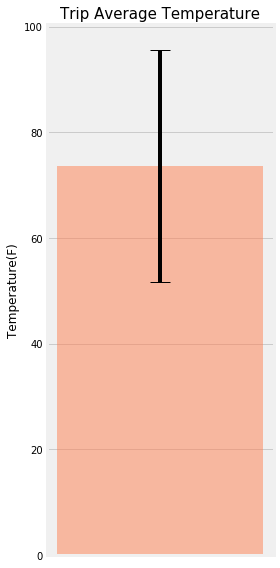

In [12]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Trip Average Temperature', fontsize=15)
ax.set_ylabel('Temperature(F)')
ax.set_ylim(auto=True)
ax.set_xticks([])

ax.bar(0, measurements[1], yerr=(measurements[2] - measurements[0]), align='center', alpha=0.5, ecolor='black', capsize=10, color='coral')

ax.grid(True)
fig.tight_layout()

### Daily Rainfall Average
_____

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

query = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    join(Measurement, Station.station == Measurement.station).\
    group_by(Station.station).\
    filter(func.Date(Measurement.date) >= func.Date(p_trip_start_date)).\
    filter(func.Date(Measurement.date) <= func.Date(p_trip_end_date)).\
    order_by(func.sum(Measurement.prcp).desc())

rainfall = pd.read_sql(query.statement, session.bind, index_col='station')
rainfall.head(10)

,name,latitude,longitude,elevation
station,,,,
USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


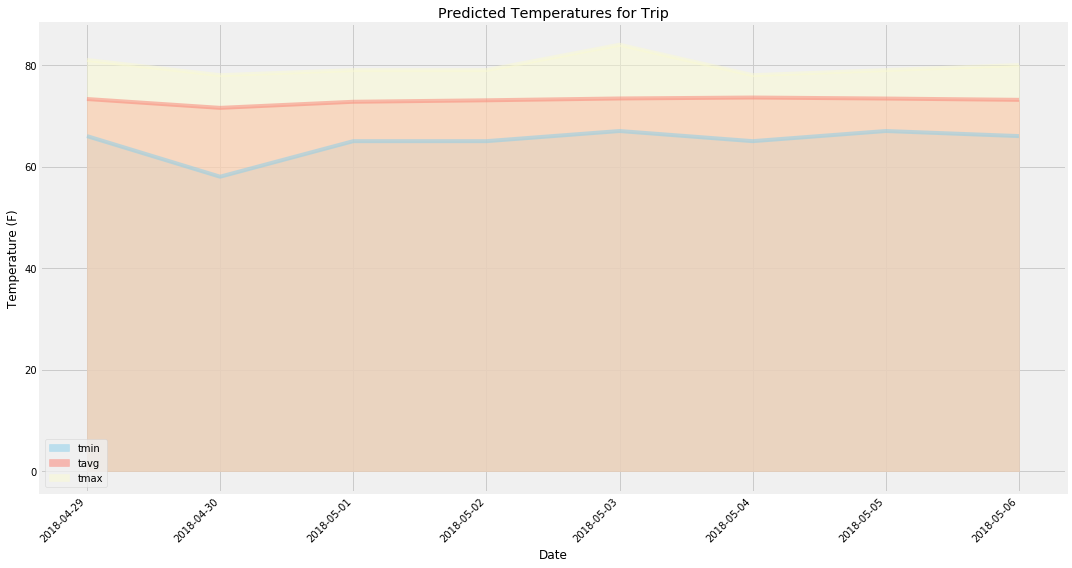

In [14]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

trip_dates = pd.date_range(trip_start_date, trip_end_date)
temps = []

for trip_date in trip_dates.strftime('%m-%d'):
    temps.append(*daily_normals(trip_date))

df_normals = pd.DataFrame(temps, columns = ['tmin', 'tavg', 'tmax'])
df_normals['Date'] = trip_dates
df_normals.set_index('Date', inplace=True)

colors=['skyblue', 'salmon', 'lightgoldenrodyellow']
df_normals.plot(kind='area', figsize=(15, 8), stacked=False, x_compat=True, color=colors, title='Predicted Temperatures for Trip', rot=45)

plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.autoscale(enable=True,axis='both')

plt.grid(True)
plt.legend(loc='lower left')

plt.tight_layout()